# **Topic Modelling using Gensim and Mallet**

Our goal here is to present a basic overview of the library that covers the following aspects:

   - Topic Modeling
   - Word and Document Vector Representation
   - Semantic Similarity Calculation

In [ ]:
# Common imports
import numpy as np
import pandas as pd
import zipfile as zp
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
#To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
#For fancy table Display
# %load_ext google.colab.data_table

## **1. What is Gensim**

---

<figure>
<center>
<img src='https://radimrehurek.com/gensim_4.0.0/_images/gensim_logo_positive_complete_tb.png' width="600"></img>
<figcaption>Source: https://radimrehurek.com/gensim_4.0.0/_images/gensim_logo_positive_complete_tb.png</figcaption></center>
</figure>

Gensim is a Python library intended for NLP practitioners. It provides a variety of methods for working with documents in textual format and carrying out semantic analysis tasks such as topic modeling or semantic comparison between documents. For this reason, Gensim is also widely used in Information Retrieval (IR) tasks.

Gensim is Open Source and is entirely programmed in Python, so it is easy to modify the code if necessary. The source code is hosted on the [Github development repository](https://github.com/RaRe-Technologies/gensim
).

Despite being fully developed in Python, Gensim makes extensive use of the Numpy and Scipy libraries that provide highly efficient implementations of certain matrix transformations and mathematical calculations, so Gensim is quite fast. For this reason, Gensim has been adopted by a large number of companies as a core components of complex NLP systems. Gensim is available for its use in the main Cloud Computing platforms (AWS, Azure, Google, etc).


---
**Important**:

Current Gensim version available in Colab does not support some tools designed to support third-party software, such as the Mallet wrapper, that were available in earlier versions. For this reason, this Notebook makes use of Gensim v3.8.3 since it is the last release in which this wrapper is available. It is important to update to this version, since versions prior to 3.7 contain bugs in the use of said wrapper for Mallet.

---

In [ ]:
#!pip install --upgrade gensim==3.8.3

### *1.1. Gensim Features*

Gensim offers multiple functions oriented to the calculation of vector representations of documents, to the modeling of topics, and to the calculation of semantic distances between documents. On the other hand, it does not offer a wide catalogue of functions for text preprocessing (e.g., lemmatization), so we will typically use Gensim on documents previously preprocessed with other specific libraries for this purpose, such as spaCy.

Gensim's design principles are:

   - **Reliability**: Inclusion of widely tested algorithms that can be deployed with guarantees in real systems. Like spaCy, it is not a particularly useful library from an academic point of view, although the fact that all its own code is developed in Python makes it easy to modify it for academic and research purposes.

   - **Scalability**: Gensim is programmed to allow working with large corpus of data. The implementations use data streaming that make it easy to iterate procedures over datasets that do not need to be stored in RAM memory (i.e., predominance of iterables over lists).

   - **Efficiency**: The use of Numpy and Scipy for expensive tasks, as well as the multicore implementation of various algorithms, provides efficient implementations of the included algorithms.

### *1.2. Gensim Algorithms*

The following algorithms are included in Gensim

   - Basic Text Preprocessing tools (Tokenizer, Porter Stemmer, stopword removal, short token removals). On the other hand, it includes an algorithm for N-gram identification that is based on efficient calculation of the frequency of terms co-occurrence.
   
   - Algorithms for Document Vectorization: From rawtext to Bag of Words or TFIDF representation.

   - Algorithms for Word and Document Vectorization based on Deep Neural Networks: Word2Vec, Doc2Vec, Fasttext. Pretrained models are available as well as the possibility to fine tune them or train from scratch. However, GPU optimization is not provided (you need to use PyTorch, Keras, ... for that).

   - Algorithms for Topic Modeling: Latent Semantic Indexing (LSI), Latent Dirichlet Allocation (LDA), Dynamic (LDA), Hierarchical Dirichlet Process (HDP), Non-negative Matrix Factorization (NMF). Topic coherence calculation.

   - Algorithms for computing semantic similarities: Among documents, among topics from the same or different models, among words, etc.

Gensim includes also a wide variety of utility functions to convert from Gensim representation to the text formats used by other common Topic Modeling libraries (e.g., Blei LDA implementation, Mallet).

For a complete description of all Gensim available tools, please refer to the [API documentation](https://radimrehurek.com/gensim_4.0.0/apiref.html).

### 1.3. *Gensim and other Libraries for NLP*

   - **spaCy** should be preferred for text preprocessing tasks. It offers more efficient and highly customizable NLP pipelines.
   - **scikit-learn**: should be preferred for classification or regression tasks. When this is the case, using sklearn TFIDF vectorizer followed by the classifier or regressor or your choice (including possibility of cross-validation of parameters) is extremely simple. Sklearn implementation for topic modeling is based on online LDA and could be a reasonable choice if we only care about the topics. However, Gensim offers more flexibility, a more memory efficient implementation, and a wide catalogue of support functions for semantic similarity. In short, it is more powerful than scikit learn for NLP and IR tasks.
   - **Blei LDA implementation**: It is the original implementation of the author of the LDA algorithm. It is very accurate with respect to LDA optimization. Being implemented in C is highly efficient, but cannot be parallelized. Furthermore, it requires specific text formats for the input and output data. If you want to use this implementation, Gensim can build these files for you.
   - **Mallet Topic Modeling Toolbox**: A very efficient Java implementation of LDA based on Monte Carlo sampling. Highly efficient and accurate. In my opinion, probably a the best implementation you can use for LDA regarding the performance vs accuracy balance. As said, it is implemented in Java, but the good news is that Gensim (up to v3.8) provides a wrapper for Mallet, so all you need to do is download the executable file, and tell Gensim where it can find it.

## **2. Data loading and preprocessing**
---

In this notebook you will work with a collection of project descriptions taken from projects funded by the National Science Foundation (NSF), the main US funder for basic research, in 2018. This information has been obtained from the open data available at the [NSF website](https://www.nsf.gov/data/). In order to simplify the resolution of this notebook, you can use the provided file, where project descriptions have already been preprocessed and lemmatized.

Alternatively, you can use any dataset you like to carry out topic analysis in a dataset of your interest. However, note that in order to obtain good results, <mark>it is recommended that the selected corpus has been previously preprocessed and lemmatized using the pipeline that you implemented in the spaCy Tutorial.</mark> You can use the preprocessed data from the NSF dataset, or any other data source you have generated.

It is recommended to keep the number of documents around 10,000. In this way, you will be able to train the models in a reasonable time during the execution of the tutorial. An excessively low number of documents will make the trained topic models poorly interpretable.

If you do not yet have a preprocessed set of documents as described, you can use the subset of NSF pre-processed data available in file *NSF2018_lemmas.txt*. Each line of the file corresponds to a different document.

In [ ]:
mycorpus = open('NSF2018_lemmas.txt').readlines()
mycorpus = [el.strip().split() for el in mycorpus]

print(colored('Number of documents in corpus: '+str(len(mycorpus)), 'green'))
print(colored('\n============= First document in corpus =============', 'blue'))
print(mycorpus[0])
print(colored('\n============= Corresponding Python string =============', 'blue'))
print(' '.join(mycorpus[0]))

Number of documents in corpus: 9446

============= First document in corpus =============
['molecular', 'mechanisms', 'bacterial', 'helicase', 'assembly', 'activation', 'replication', 'origin', 'goal', 'work', 'understand', 'essential', 'feature', 'dna', 'replication', 'structure', 'analysis', 'assembly', 'bacterial', 'dnab', 'replicative', 'helicase', 'origin', 'dna', 'replication', 'replicative', 'helicase', 'unwind', 'duplex', 'dna', 'template', 'replication', 'contrast', 'extensive', 'understanding', 'translocation', 'dnab', 'single', 'strand', 'dna', 'ssdna', 'little', 'know', 'mechanism', 'helicase', 'opening', 'helicase', 'assembly', 'ssdna', 'closing', 'helicase', 'mediate', 'helicase', 'loader', 'research', 'address', 'main', 'mission', 'scientist', 'teacher', 'attract', 'retain', 'student', 'stem', 'science', 'technology', 'engineering', 'mathematic', 'field', 'prepare', 'educate', 'citizenry', 'century', 'city', 'college', 'new', 'york', 'ccny', 'additional', 'mission', 'pro

In order to be able to work with the corpus, we need to vectorize all its documents. To do so, the next cells carry out the following actions

0. N-gram detection
1. Calculate the dictionary
2. Calculate BoW and TFIDF for documents in corpus

Note that you already implemented these procedures in notebook `Text_Vectorization_I`.

### *2.1. N-gram detection and replacement*



In [ ]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(mycorpus, min_count=2, threshold=20)

print(colored('\n============= First document in corpus =============', 'blue'))
print(mycorpus[0])
mycorpus = [el for el in phrase_model[mycorpus]] #We populate mycorpus again
print(colored('\n============= First document after N-gram replacement =============', 'blue'))
print(mycorpus[0])



============= First document in corpus =============
['molecular', 'mechanisms', 'bacterial', 'helicase', 'assembly', 'activation', 'replication', 'origin', 'goal', 'work', 'understand', 'essential', 'feature', 'dna', 'replication', 'structure', 'analysis', 'assembly', 'bacterial', 'dnab', 'replicative', 'helicase', 'origin', 'dna', 'replication', 'replicative', 'helicase', 'unwind', 'duplex', 'dna', 'template', 'replication', 'contrast', 'extensive', 'understanding', 'translocation', 'dnab', 'single', 'strand', 'dna', 'ssdna', 'little', 'know', 'mechanism', 'helicase', 'opening', 'helicase', 'assembly', 'ssdna', 'closing', 'helicase', 'mediate', 'helicase', 'loader', 'research', 'address', 'main', 'mission', 'scientist', 'teacher', 'attract', 'retain', 'student', 'stem', 'science', 'technology', 'engineering', 'mathematic', 'field', 'prepare', 'educate', 'citizenry', 'century', 'city', 'college', 'new', 'york', 'ccny', 'additional', 'mission', 'provide', 'high', 'quality', 'education

**Exercise 1:** Create a table containing all detected N-grams and the number of ocurrences of each N-gram in the corpus.

   - How many N-grams did the method identify?
   - What are the most frequent N-grams in the corpus?

In [ ]:
'''#<SOL>
print(len(mycorpus[0]))
datalist = []
for elem in mycorpus[0]:
  datalist.append({elem:})
#</SOL>
Ngrams_df'''


'#<SOL>\nprint(len(mycorpus[0]))\ndatalist = []\nfor elem in mycorpus[0]:\n  datalist.append({elem:})\n#</SOL>\nNgrams_df'

### *2.2. Dictionary calculation and vector representations*

---

Note: We will proceed without N-gram detection since we did not carry out a careful selection of the threshold. If you want to keep N-grams, you just need to comment the first two lines of the code fragment, but a finer tuning of the N-gram model from Subsection `2.1.` is advised to get higher quality topics.

---

In [ ]:
mycorpus = open('NSF2018_lemmas.txt').readlines()
mycorpus = [el.strip().split() for el in mycorpus]

from gensim.corpora import Dictionary

no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

# Create dictionary of tokens
D = Dictionary(mycorpus)
D.filter_extremes(no_below=no_below,no_above=no_above)

n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 12453 terms
First terms in the dictionary:
0 : activation
1 : additional
2 : address
3 : adoption
4 : aim
5 : analysis
6 : assembly
7 : associate
8 : attention
9 : attract


In [ ]:
# Esto es una lista de BoW (id_palabra_dicc, n_ocurrencias) que contiene un BoW para cada documento del corpus
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

n_project = 1000
print(colored('============= Project abstract (lemmas) =============', 'blue'))
print(' '.join(mycorpus[n_project]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(mycorpus_bow[n_project])

print(colored('\n============= Word counts for the project =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), mycorpus_bow[n_project])))

============= Project abstract (lemmas) =============
statistical mechanic area theoretical physics predict macroscopic behavior physical system give microscopic dynamic dynamic classical quantum equilibrium statistical mechanic foundational work go boltzmann gibbs formulate principle procedure microscopic dynamic description macroscopic system carry procedure difficult broad outline understand physical system equilibrium main interest long time behavior gaussian distribution familiar bell shape curve important universality apply wide variety unrelated problem underlie common theme problem fact object study degree independence state physical term non interact interact type problem understand foundation nonequilibrium statistical physics understand equilibrium statistical physics particular process involve interact particle project direct understand process interact satisfactory general theory exist non interact case model occupy big role understand system equilibrium asymmetric exclusi

In [ ]:
from gensim.models import TfidfModel

tfidf = TfidfModel(mycorpus_bow)

#Notice square brackets
mycorpus_tfidf = tfidf[mycorpus_bow]
n_project = 1000
print(colored('============= TFIDF representation for the project =============', 'blue'))
print(mycorpus_tfidf[n_project])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[mycorpus_bow[n_project]])


============= TFIDF representation for the project =============
[(44, 0.04036036821890844), (46, 0.034178690719234905), (60, 0.035569315170911414), (72, 0.037402586636872785), (75, 0.04406373674938159), (83, 0.06892871858851884), (85, 0.01663198295603937), (101, 0.06696645207782019), (138, 0.08229344302760319), (140, 0.027763426675780613), (160, 0.03336421159569198), (181, 0.03299384220295223), (220, 0.06518218966149723), (232, 0.05050413708212838), (239, 0.0860195959996164), (240, 0.09580169888008228), (263, 0.04745385437708976), (300, 0.04326959101863456), (318, 0.21725890517156596), (319, 0.03011708337717091), (340, 0.06655587735495105), (359, 0.019591595612315264), (361, 0.021655796320805883), (362, 0.05760178045366014), (364, 0.017318710144783627), (369, 0.028897366553777858), (374, 0.03143037087935588), (378, 0.020761857239006073), (399, 0.02437230819683857), (422, 0.06683464029026306), (442, 0.029081284383716793), (457, 0.2720796278446136), (466, 0.03011708337717091), (473, 0.0

## **3. Topic Modeling with Gensim**
---


### *3.1. Latent Semantic Indexing*

Now we are ready to apply a topic modeling algorithm. Latent Semantic Indexing (LSI) is provided by LsiModel. Note that LSI by carryint out the SVD of either the BoW or TFIDF data representation matrices. However, it is generally accepted that better results are obtained from LSI when using the TFIDF representation.

**Exercise 2**: Generate an LSI model with 10 topics for `mycorpus_tfidf` and dictionary `D`. You can check the sintaxis for [gensim.models.LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html) in order to solve the exercise.

In [ ]:
from gensim.models import LsiModel

# Initialize an LSI transformation
n_topics = 10

lsi = LsiModel(mycorpus_tfidf[:10] , id2word=D, num_topics=n_topics)


From LSI, we can check both the topic-tokens matrix and the document-topics matrix.

   - `topic-tokens` matrix provides the weight (either positive or negative) that each token has for every token. Note that token relevance is normally measured from the absolute value of the weight, with positive/negative weights corresponding to tokens that are important/uncorrelated with the topic.

   - `document-topics`matrix provides the weight (either positive or negative) of each topic for a particular document. Topics with a positive weight are positively correlated with the document, whereas negative weights imply a negative contribution of the topic for the document.

#### 3.1.1. Displaying topic information


A first visualization of the obtained topics is provided by the `show_topics` method.

In [ ]:
#Display all topics including 10 most relevant tokens per topic
lsi.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.187*"dewetting" + 0.159*"crest" + 0.148*"mach" + 0.135*"film" + 0.134*"helicase" + 0.133*"rack" + 0.133*"pwi" + 0.132*"tensor" + 0.120*"biogeochemistry" + 0.118*"model"'),
 (1,
  '-0.318*"mach" + 0.175*"rack" + 0.174*"crest" + -0.168*"tensor" + 0.153*"pwi" + -0.138*"solver" + -0.138*"flow" + -0.131*"multidimensional" + -0.130*"incompressible" + -0.129*"decomposition"'),
 (2,
  '-0.405*"pwi" + -0.306*"helicase" + -0.246*"msi" + -0.198*"qos" + -0.162*"cloud" + 0.145*"dewetting" + -0.125*"network" + -0.124*"overlay" + -0.124*"internet" + 0.122*"microscope"'),
 (3,
  '-0.709*"helicase" + 0.223*"pwi" + -0.159*"replication" + -0.143*"dna" + 0.135*"msi" + 0.120*"qos" + -0.107*"replicative" + 0.098*"cloud" + -0.096*"origin" + -0.091*"assembly"'),
 (4,
  '-0.295*"helicase" + 0.222*"biogeochemistry" + 0.215*"uncertainty" + -0.201*"crest" + 0.194*"mach" + 0.174*"pwi" + 0.156*"anthropogenic" + 0.130*"ocean" + 0.118*"cesm" + 0.116*"intercomparison"'),
 (5,
  '0.293*"pwi" + -0.287*"crest" 

A more useful representation of a particular topic can be obtained using the `show_topic` method that returns a list of tuples (token, value). This is provided by the show_topic method. Check below the output of this function for a particular topic. The function returns the requested number of tokens sorted by decreasing absolute value of the topic-weight.

In [ ]:
lsi.show_topic(3, topn=25)

[('helicase', -0.709028777420132),
 ('pwi', 0.22308467761931952),
 ('replication', -0.15935876864065912),
 ('dna', -0.14280497168158696),
 ('msi', 0.1354507717913044),
 ('qos', 0.11975222234271723),
 ('replicative', -0.10686871600789793),
 ('cloud', 0.09807663425349572),
 ('origin', -0.09576493547228808),
 ('assembly', -0.09103750582065186),
 ('rack', -0.09099033009549451),
 ('bp', -0.08963165297316647),
 ('microscope', 0.08187074929628799),
 ('overlay', 0.07510975891695262),
 ('internet', 0.07495039186253308),
 ('network', 0.07238596417313412),
 ('biogeochemistry', -0.06806998455096602),
 ('counterfeit', 0.06653705294337625),
 ('nyc', -0.06611255303556823),
 ('uncertainty', -0.06604809964012827),
 ('photochromic', -0.06358848410766499),
 ('hardware', 0.06268316761713769),
 ('jeffrey', -0.06176161856873293),
 ('phage', -0.06043421476801658),
 ('crest', 0.05849881336295101)]

**Exercise 3:** Complete the following code fragment to represent the columns of the topic-token matrix as a series of bar diagrams (one per topic) with the top 25 tokens of each topic.

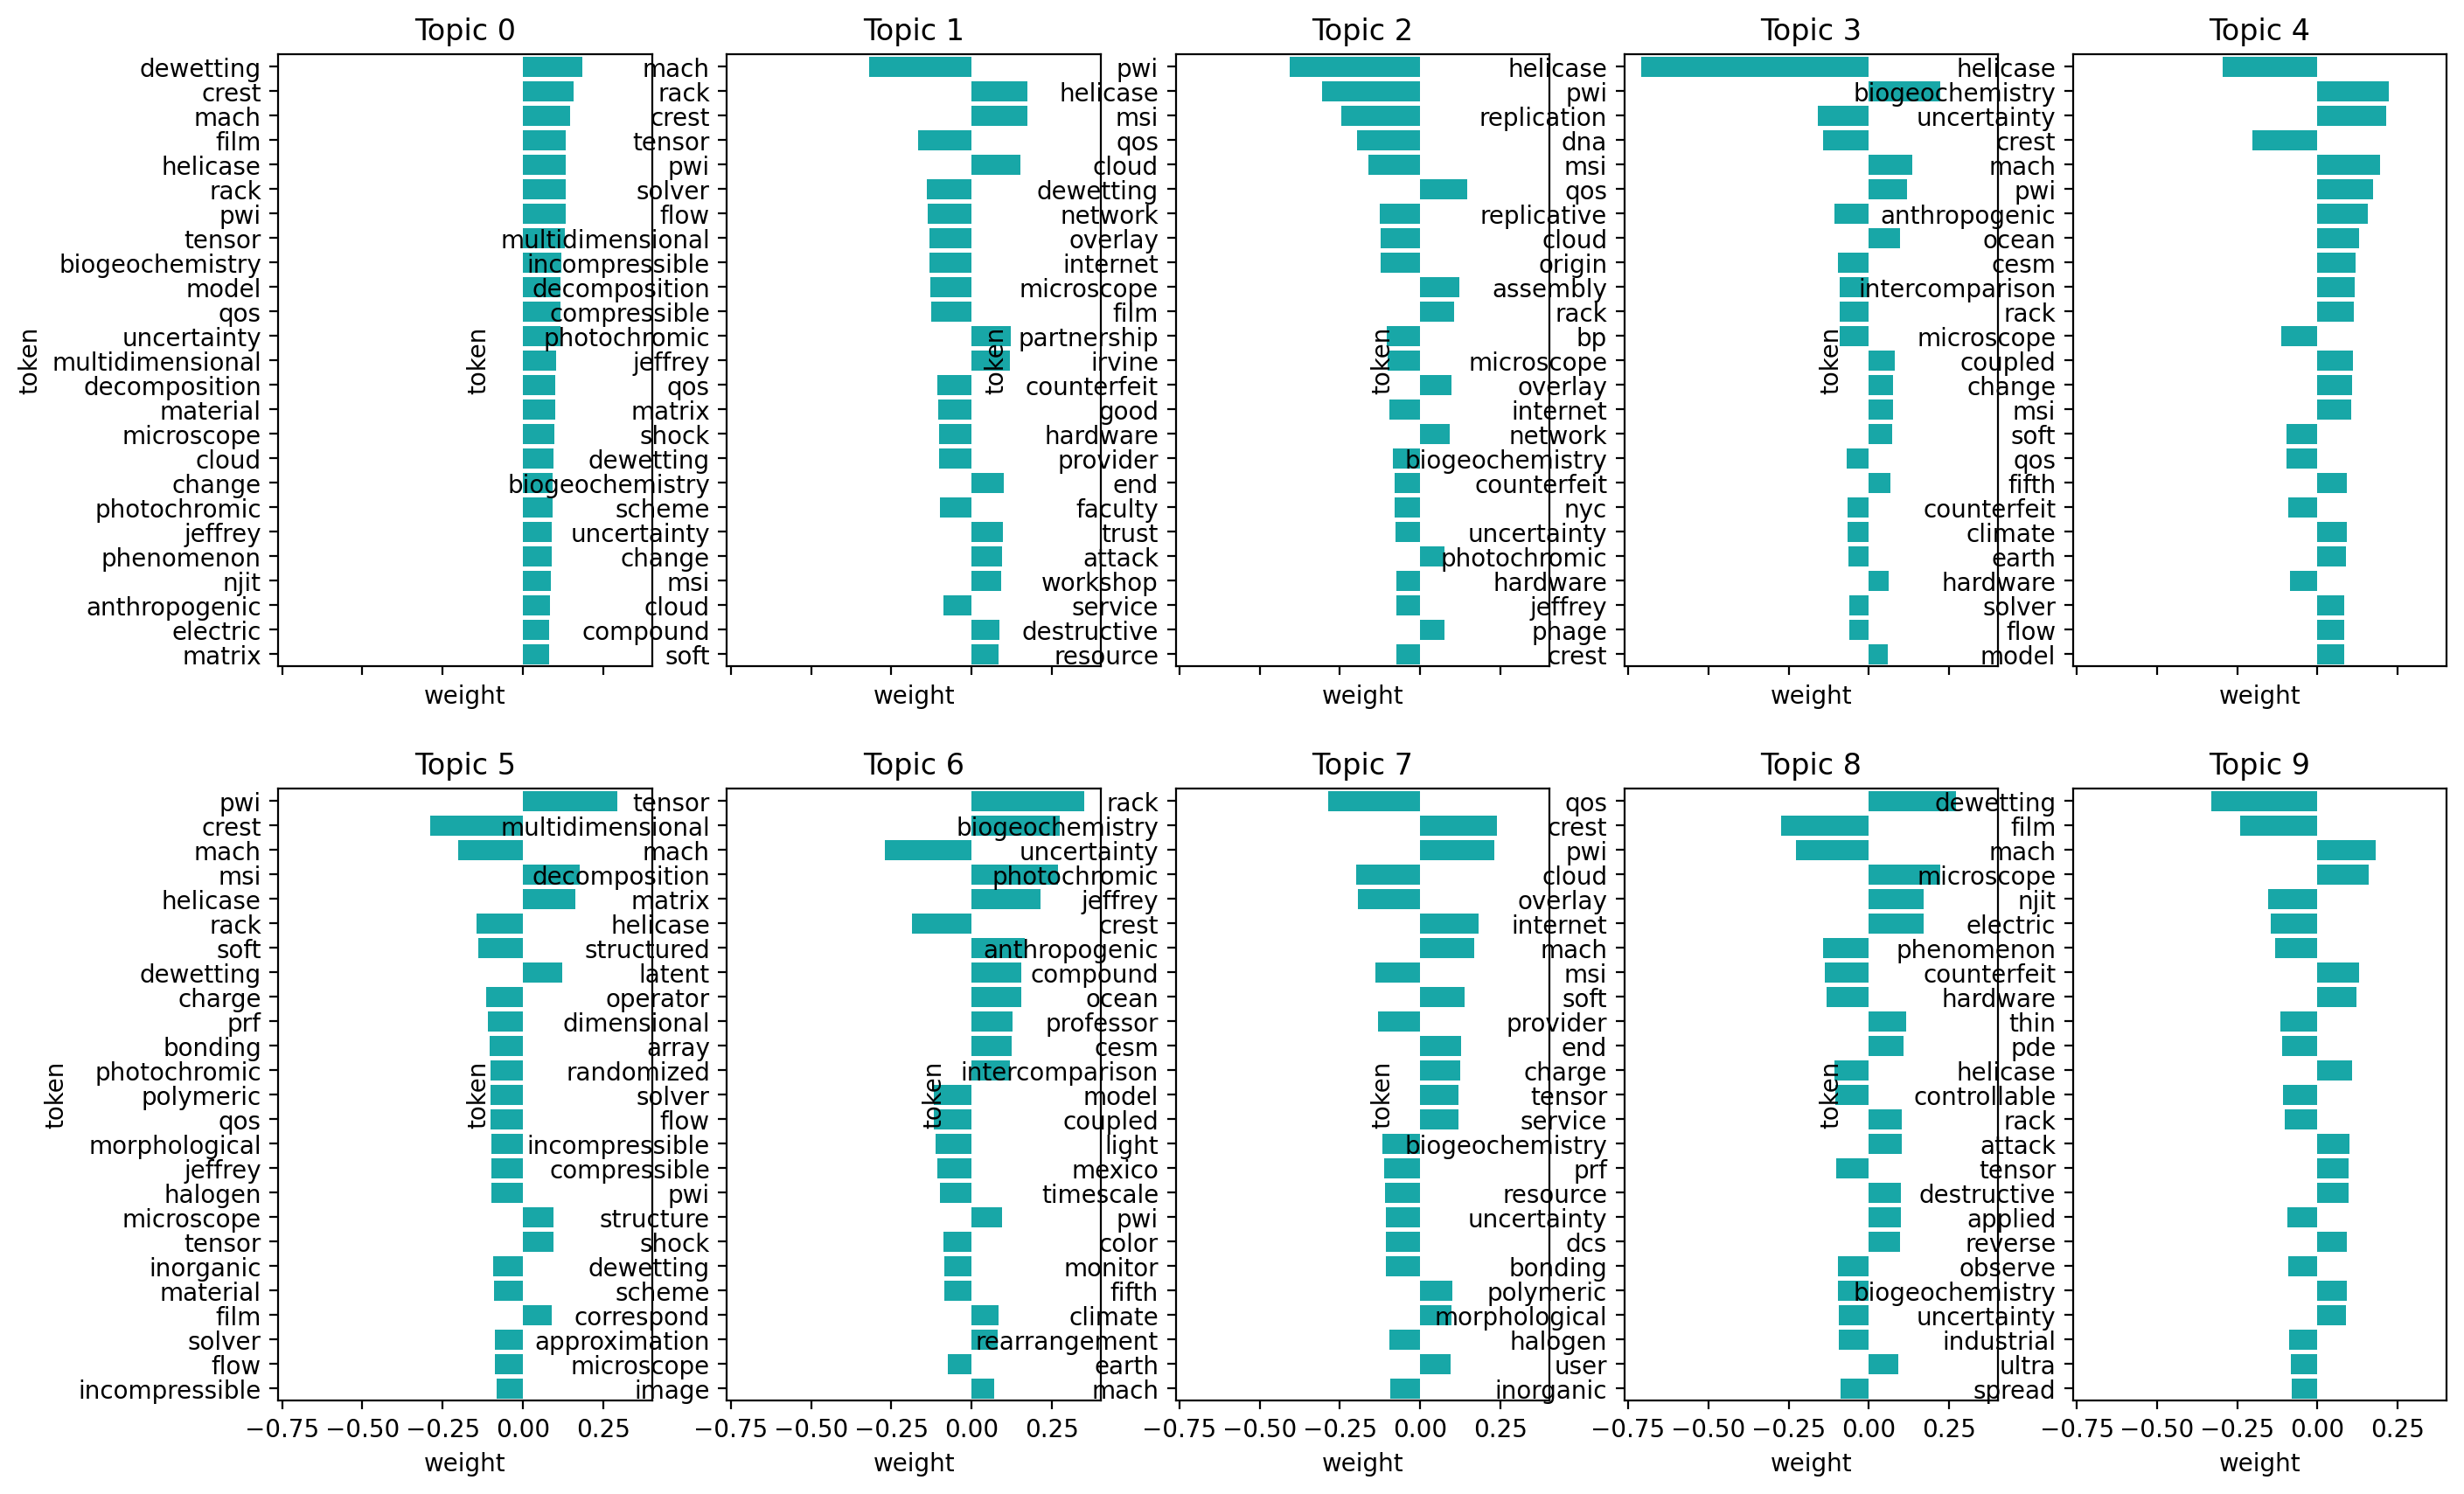

In [ ]:
topn = 25

fig, axes = plt.subplots(2, 5, figsize=(16, 10), sharex=True)

for i in range(5):
    # Construir un dataframe con columnas 'token' y 'weight' para el tópico i con el número de tokens más relevantes que se ha pedido
    df_topic = pd.DataFrame(lsi.show_topic(i, topn=topn), columns=['token', 'weight'])

    sns.barplot(x='weight', y='token', data=df_topic, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))

for i in range(5, 10):
    # Construir un dataframe con columnas 'token' y 'weight' para el tópico i+5
    df_topic = pd.DataFrame(lsi.show_topic(i, topn=topn), columns=['token', 'weight'])

    sns.barplot(x='weight', y='token', data=df_topic, color='c', orient='h', ax=axes[1][i-5])
    axes[1][i-5].set_title('Topic ' + str(i))

plt.show()

**Discussion**:

   - Taking a look at the previous plots, can you find some intuitive topics?
   - Can you distinguish the significance of positive vs negative weights?
   - Which terms would you keep to better characterize the topics: positive, negative, both?
   - What do you think is the role of Topic 0?

You can play with changing the number of topics to check whether you can find more detailed topics. Normally, more detailed topics come at the cost of adding some noisy topics.

#### 3.1.2. Displaying document topic information

LSI approximates any document as a linear combination of the topic vectors. We can compute the topic weights for any input corpus entered as input to the lsi model.

Notice that, from the point of view of Gensim, the lsi model constitutes a transformation, just like the tfidf object. This means that:

   - You can use it to obtain the LSI representation of a particular document or to transform a whole corpus.
   - You can use a transformed corpus as document feature representation for another Machine Learning Task. For instance, you could try to solve a classification or regression task using the LSI representation of each document as the input to the classifier/regression model, as you would do with the BoW or TFIDF vectors

As LSI is based on SVD decomposition, the topic representation of any document will generally contain non-zero weights for all topics.

As with other Gensim objects, you can serialize the LSI model for future use. In order to save the model, use the `save` method of the `gensim.models.lsimodel` object.

In [ ]:
corpus_lsi = lsi[mycorpus_tfidf]
print(corpus_lsi[0])

[(0, 0.18167439363407545), (1, 0.01064670865240457), (2, -0.3486306579017845), (3, -0.8033091714649537), (4, -0.3330292412319739), (5, 0.18362933189644254), (6, -0.20515384113604007), (7, -0.014342316794798188), (8, 0.006467128633067038), (9, 0.1143165356318654)]


**Exercise 4**: Try to locate a topic related to *Astrophysics*, and find the most relevant document for such topic. In order to do so, you should take into account whether the relevant tokens for the topic have been assigned positive or negative values in the `topic-tokens` matrix. The *most relevant document* will be that with the largest or smallest component for the topic.

Observe the document text representation to check whether the selected document was reasonably characterized by the topic.

(If you are working with your own dataset, pick another topic from the model you obtained)

In [ ]:
#<SOL>
# El tópico más relacionado con astrofísica es el *4*
doc_id = None
max = 0
# Recorres cada documento del corpus
for i in range(len(corpus_lsi)):
  # Recorres los tópicos que tiene cada documento
  for j in range(len(corpus_lsi[i])):
    # Si aparece el tópico que buscamos (4) y su valor absoluto es mayor que el máximo que hemos puesto nos lo guardamos como nuevo valor max
    if corpus_lsi[i][j][0] ==4 and abs(corpus_lsi[i][j][1]) > max:
      doc_id = i
      max = corpus_lsi[i][j][1]
print("Documento más relevante: " + str(doc_id) + " con un weight de", str(max))

#</SOL>

Documento más relevante: 8con un weight de 0.5575637806495763


### *3.2. Latent Dirichlet Allocation*

Since we already have computed the dictionary and documents BoW representation using Gensim, computing the topic model is straightforward using the `LdaModel()` function.

Like the implementation in scikit-learn, Gensim LDA is based on [Online LDA](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.984.3103&rep=rep1&type=pdf). Gensim implementation is:
   - *memory efficient*: the input data (BoW representation) just need to be a Python iterator. This means that the corpus does not have to reside in memory allowing to train with corpus larger than the available RAM.
   - *distributed*: allows training using multiple cores for faster execution.

Please, refer to [Gensim API documentation](https://radimrehurek.com/gensim/models/ldamodel.html) for more information on the different parameters accepted by the function. Take a look at the possible choices for the parameters related LDA Dirichlet prior hyperparameters `alpha`, and `eta`.

**Important**: Unlike LSI, LDA generative model is based on BoW document representation. Therefore, you should **always** use BoW representation when searching for LDA models.


In [ ]:
from gensim.models.ldamodel import LdaModel
num_topics = 20

ldag = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=num_topics)

#### 3.2.1. Displaying topic information

A first visualization of the obtained topics is provided by the show_topics method.

In [ ]:
#Display all topics including 10 most relevant tokens per topic
ldag.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.013*"student" + 0.011*"site" + 0.009*"program" + 0.008*"datum" + 0.008*"provide" + 0.008*"science" + 0.007*"health" + 0.007*"reu" + 0.006*"include" + 0.006*"scientific"'),
 (1,
  '0.014*"particle" + 0.012*"flow" + 0.010*"model" + 0.009*"high" + 0.008*"new" + 0.008*"energy" + 0.007*"study" + 0.006*"experiment" + 0.006*"large" + 0.006*"turbulent"'),
 (2,
  '0.017*"chemical" + 0.013*"chemistry" + 0.012*"student" + 0.012*"reaction" + 0.010*"molecule" + 0.009*"protein" + 0.009*"molecular" + 0.008*"program" + 0.008*"catalyst" + 0.008*"study"'),
 (3,
  '0.031*"student" + 0.012*"science" + 0.012*"program" + 0.010*"engineering" + 0.009*"education" + 0.009*"stem" + 0.008*"development" + 0.008*"develop" + 0.007*"community" + 0.007*"provide"'),
 (4,
  '0.015*"theory" + 0.015*"conference" + 0.010*"student" + 0.009*"study" + 0.009*"problem" + 0.008*"mathematical" + 0.007*"new" + 0.007*"group" + 0.007*"field" + 0.007*"equation"'),
 (5,
  '0.011*"wave" + 0.009*"earthquake" + 0.008*"star" + 0

**Exercise 5:** Like you did for the LSI model, provide a graphic interpretation of token composition of the topics you obtained.

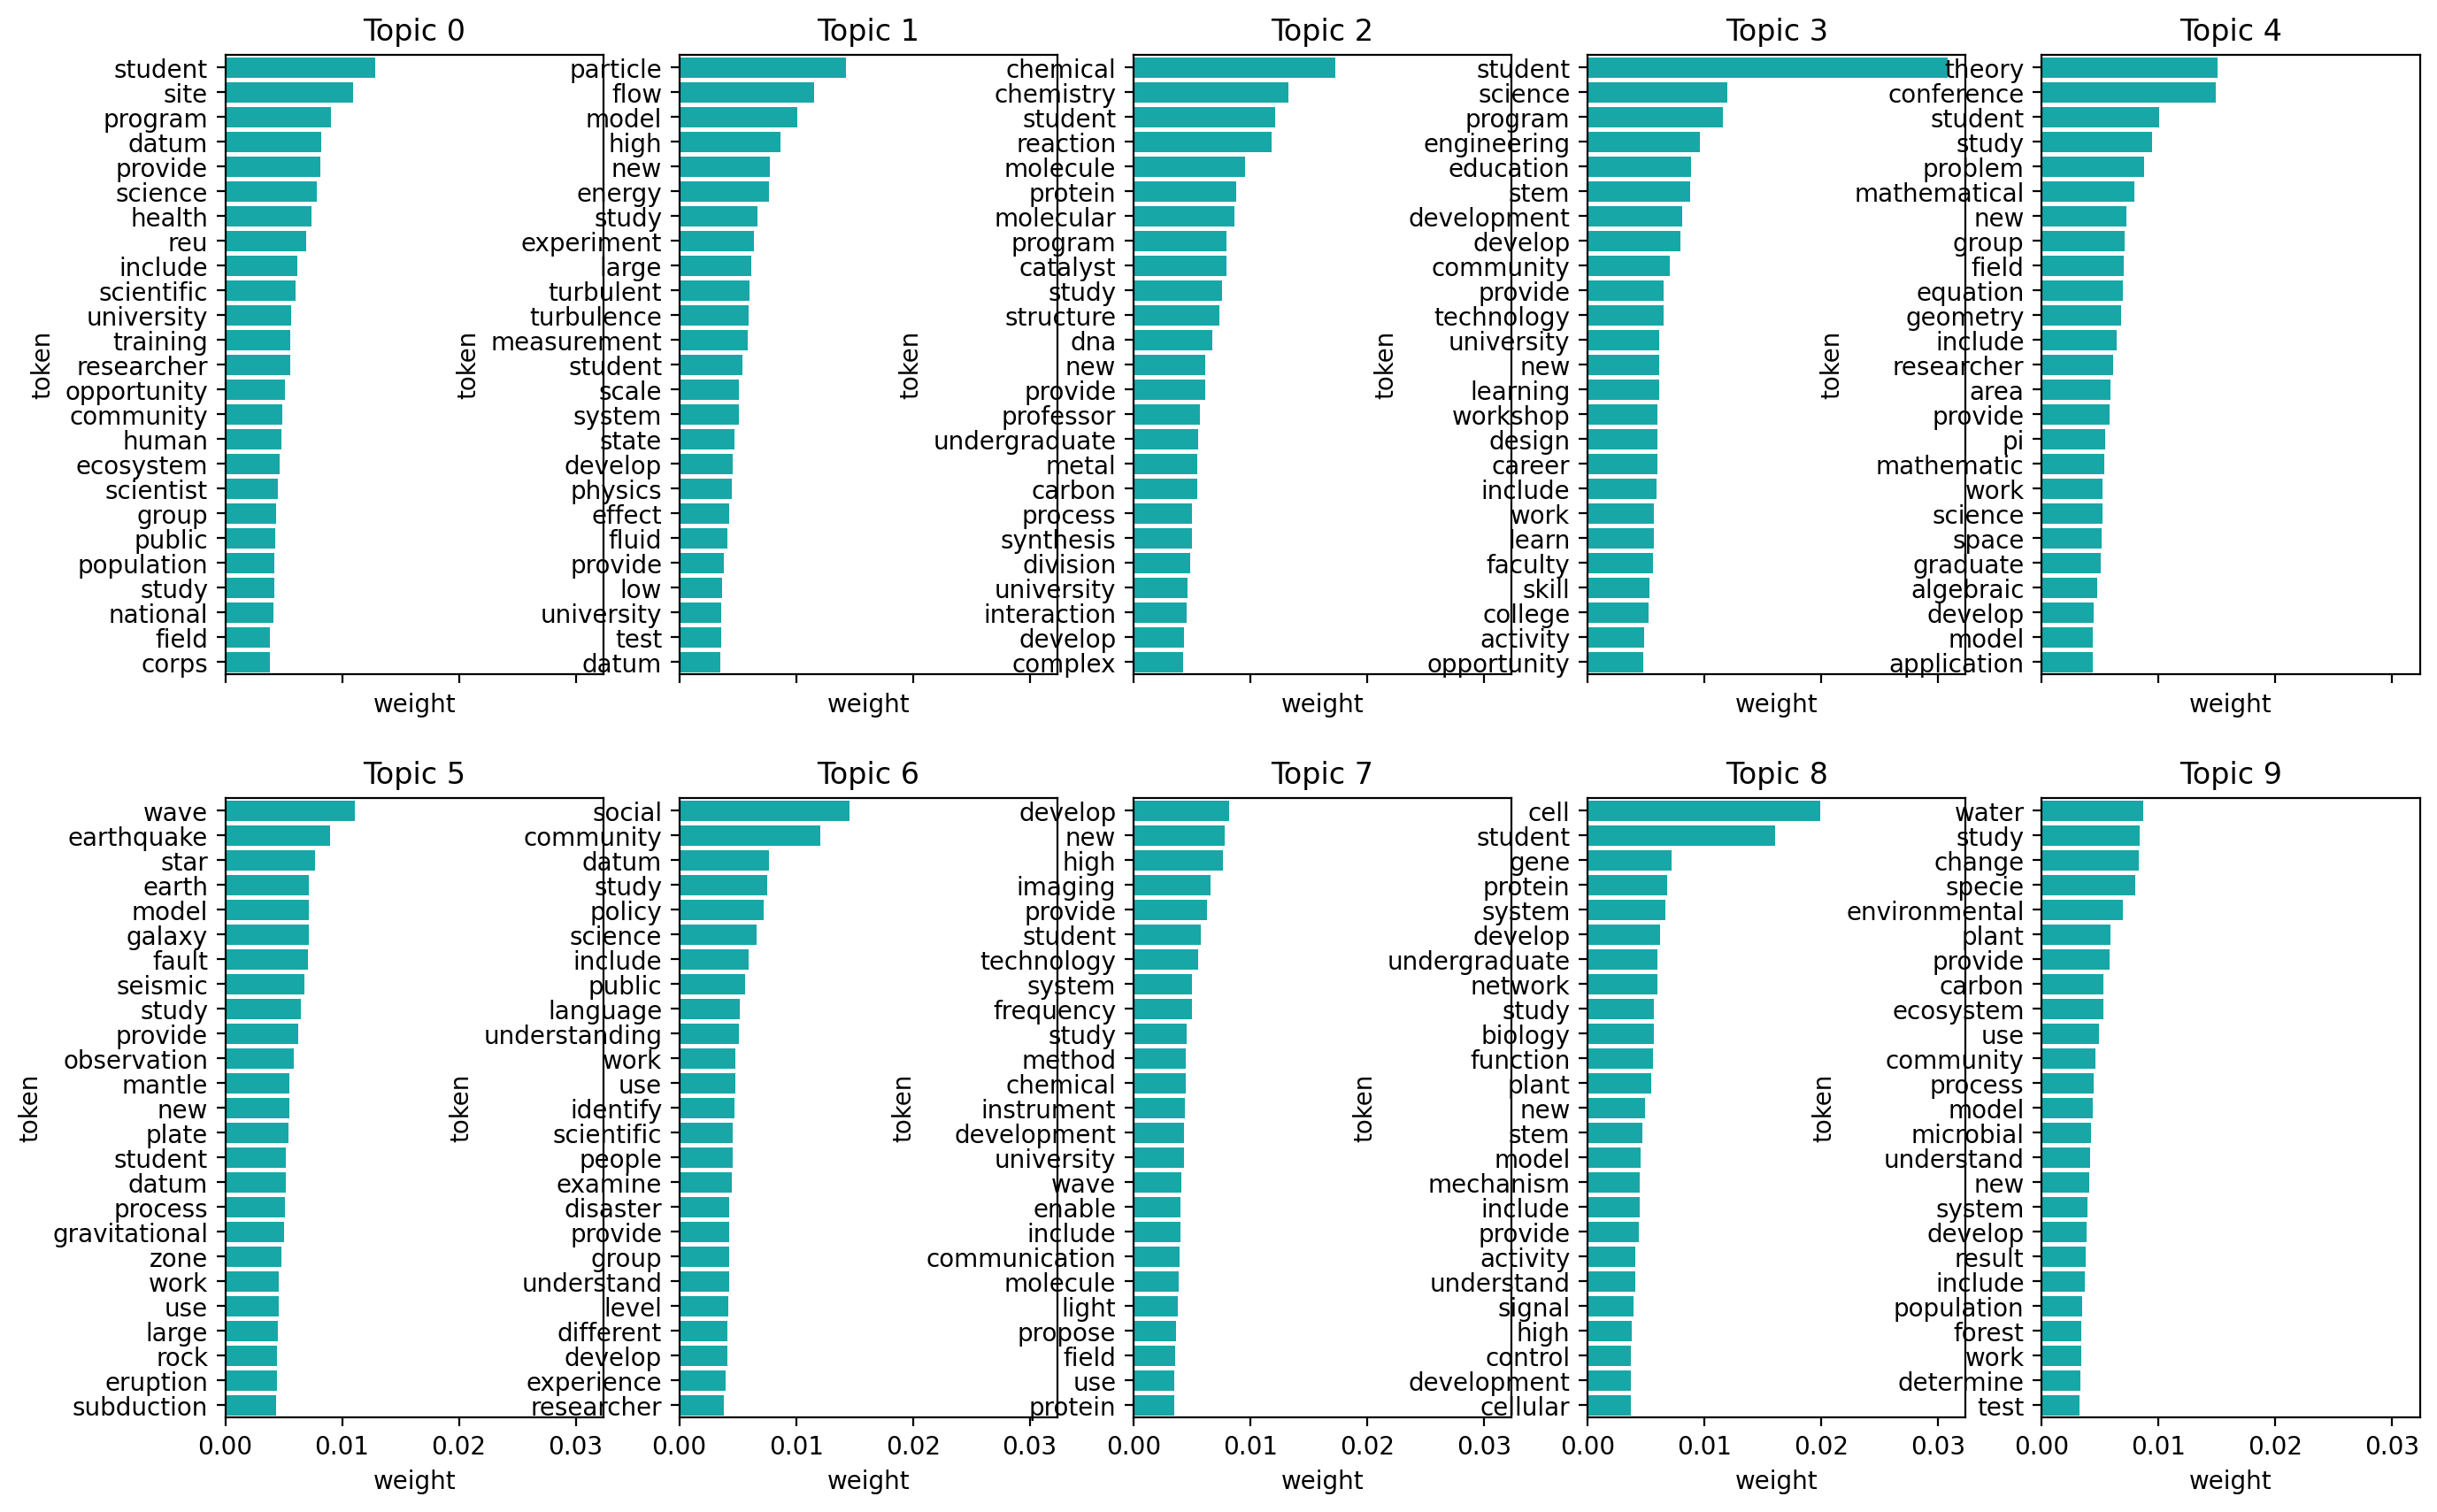

In [ ]:
topn = 25

fig, axes = plt.subplots(2, 5, figsize=(16, 10), sharex=True)

for i in range(5):
    # Construir un dataframe con columnas 'token' y 'weight' para el tópico i
    df_topic = pd.DataFrame(ldag.show_topic(i, topn=topn), columns=['token', 'weight'])

    sns.barplot(x='weight', y='token', data=df_topic, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))

for i in range(5, 10):
    # Construir un dataframe con columnas 'token' y 'weight' para el tópico i+5
    df_topic = pd.DataFrame(ldag.show_topic(i, topn=topn), columns=['token', 'weight'])

    sns.barplot(x='weight', y='token', data=df_topic, color='c', orient='h', ax=axes[1][i-5])
    axes[1][i-5].set_title('Topic ' + str(i))

plt.show()

**Discussion**:

   - Having a look a the token composition of the obtained topics, do you consider all of them equally informative, in the sense of semantic relevance?
   - Can you think of any strategy to improve the quality of the topics in terms of their token description?

#### 3.2.2. LDA model visualization: pyLDAvis

A more useful visualization is provided by the python LDA visualization library, pyLDAvis.

To execute the next code fragment you need to have pyLDAvis installed.

A brief but complete description of the information provided by LDAvis can be found [here](https://pahulpreet86.github.io/interpreting-topic-model-visualization-ldavis-package/).

---
**Important:**

Note that pyLDAvis sorts the topics according to their size in the model, so there is not a direct correspondence between the order of topics in the ldag model and pyLDAvis topic numbering

---

In [ ]:
# Install of a visualizer for LDA
!pip install pyLDAvis==2.1.2

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

vis_data = gensimvis.prepare(ldag, mycorpus_bow, D)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


#### 3.2.3. Displaying document topic information

**Exercise 6**: If you have completed the exercises proposed in the notebook, you will already understand how you can work with the ldag model created in the previous subsection, and how it can be used to transform the document corpus.

   - Obtain the vector representation of the corpus according to the assignment of documents to topics provided by the model.

   - Obtain and view some of the most relevant documents for a topic of your choice

**Exercise 7**: Build a function that returns the most relevant projects for a given topic


In [ ]:
corpus_ldag = ldag[mycorpus_bow]
print(corpus_ldag[0])
print(dir(corpus_ldag))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(2, 0.8230591), (3, 0.11960572), (6, 0.019490002), (8, 0.030829689)]
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_load_specials', '_save_specials', '_smart_save', 'add_lifecycle_event', 'chunksize', 'corpus', 'load', 'metadata', 'obj', 'save', 'save_corpus']


In [ ]:
def most_relevant_documents(ldag, topicid, corpus_bow, ndocs=10):
    """This function returns the most relevant documents in corpus_bow

    : ldag: The trained topic model object provided by gensim
    : topicid: The topic for which we want to find the most relevant documents
    : corpus_bow: The BoW representation of documents in Gensim format
    : ndocs: Number of most relevant documents to return

    : Returns: A list with the identifiers of the most relevant documents
    """

    print('Computing most relevant documents for Topic', topicid)
    print('Topic composition is:')
    print(ldag.show_topic(topicid))

    #<SOL>
    documents = []
    weights = []
    i=0
    for document in corpus_ldag:
      for elem in document:
        if elem[0] == topicid:
          documents.append((i,document, elem[1]))
      i+=1
    documents = sorted(documents, key=lambda x: x[2])
    documents = documents[:ndocs]
    output = [doc[0] for doc in documents]
    return output

#To test the function we will find the most relevant projects for one of the topics
project_id = most_relevant_documents(ldag, 8, mycorpus_bow, ndocs=3)

#Print titles of selected projects
for idproject in project_id:
    print('\n', ' '.join(mycorpus[idproject]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Computing most relevant documents for Topic 8
Topic composition is:
[('cell', 0.01996564), ('student', 0.016077898), ('gene', 0.007177549), ('protein', 0.0068368455), ('system', 0.006677764), ('develop', 0.006212517), ('undergraduate', 0.005992103), ('network', 0.005976881), ('study', 0.00572911), ('biology', 0.0056629637)]

 year life explicit instruction child acquire linguistic system allow combine sound order express meaning study process illuminate cognitive system complicate language develop human mind help clarify nature learn development learn general require build prior knowledge child learn arithmetic know count project ask infant build prior linguistic knowledge stage development limited speech able understand order learn structure language improve understanding infant learn language stage development project provide important step understanding quantity type speech hear infancy contribute difference child later vocabulary language performance school research focus acquisiti

#### 3.2.4. Using coherence to adjust the number of topics

One of the key questions when dealing with topic models is how to adjust the number of topics. There is usually a lot of trial and error in the process:

   - A too large number of topics allows to discover very detailed topics at the cost of the encountering also some unimportant and redundant topics
   - A small number normally provides semantic meaningful topics, but probably too broad. In addition to this, *garbage* topics can be seen even in this case.

A useful tool for selecting LDA hyperparameters is to use [Coherence models](https://radimrehurek.com/gensim/models/coherencemodel.html). But note that even these metrics are subject to a lot of controversy:
   - First of all, topics and model quality can be perceived in different ways by different people.
   - Second, some studies show that some coherence functions are not well correlated to human intuition when compared to the opinion of a pool of evaluators.


In [ ]:
from gensim.models.coherencemodel import CoherenceModel

coherencemodel = CoherenceModel(ldag, texts=mycorpus, dictionary=D, coherence='c_v')
print('The coherence of the trained model is', coherencemodel.get_coherence())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The coherence of the trained model is 0.40090234927424434


**Exercise 8**: Evaluate the evolution of topic coherence as a function of the number of topics. You can use, e.g.,

   - `n_topics = [5, 10, 15, 20, 25, 50]`. If the coherence does not achieve a local maximum, increase the number of topics to observe
   - Different coherence measures are implemented in Gensim. Be aware that some coherence models (like `c_v`) take a significant time to compute.


In [ ]:
#<SOL>
n_topics = [5, 10, 15, 20, 25, 50]

for n in n_topics:
  ldag = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=n)
  coherencemodel = CoherenceModel(ldag, texts=mycorpus, dictionary=D, coherence='c_v')
  print('The coherence of the trained model is', coherencemodel.get_coherence())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The coherence of the trained model is 0.3264066378030339


The coherence of the trained model is 0.36784344200251334


The coherence of the trained model is 0.4218686012708909


The coherence of the trained model is 0.4098052846222952


The coherence of the trained model is 0.4109053283097593
The coherence of the trained model is 0.4261455775172557


Apart from estimating the average coherence of the model topics, we can also use the method `get_coherence_per_topic` to select the topics with largest coherence.


#### 3.2.5. Training LDA with Mallet

As we have already explained, Mallet is a Java-based LDA implementation. It is based on Monte Carlo optimization which allows high parallelization. In addition, it generally offers very good results.

The recommended way to run Mallet is to install the executables in a local environment to be able to use it without any overhead as it happens when we use the wrapper provided by Gensim. Said wrapper requires generating auxiliary text files that are later used for Mallet training, and then the Mallet output must be parsed to retrieve the relevant information. Therefore, for a more efficient application it is more appropriate to launch Mallet executables directly. If you want to integrate such topic modeling into a Python application, you would just have to use one of the different tools that allow you to launch external processes from Python.

Despite the previous recommendation, for greater simplicity, within this notebook we will resort to the gensim wrapper, which allows us to make use of practically all the tools that we have already reviewed. However, running Mallet requires its installation in Google Colab, as well as a Java virtual machine, which we do in the following cells. We acknowledge here [this Github repository](https://github.com/polsci/colab-gensim-mallet/) from which we obtained the code.


In [ ]:
import os       #importing os to set environment variable
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
    !java -version       #check java version
install_java()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


openjdk version "11.0.21" 2023-10-17
OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we are ready to train the LDA model in pretty much the same way we did for Mallet. We adjusted two additional Mallet parameters from their default values:

   - alpha: A priori hyperparameter for the Dirichlet distribution for generating the document topic distributions
   - iterations: To get a faster execution we reduce it to 100 from its default value of 1000. In principle, more iterations provide a more accurate solution.

It should be noted that Mallet has a lot of hyperparameters that can be adjusted for data import and model training. Many but not all of them are available when using the Gensim wrapper.

In [ ]:
from gensim.models.wrappers import LdaMallet
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=20, id2word=D, alpha=5, iterations=100)


To visualize the topics obtained by LDA using Mallet, you can use any of the visualization strategies already studied in the previous subsections. However, if you wish to use pyLDAvis, it is important that you convert `ldamallet` model to an object that is fully compatible with Gensim

In [ ]:
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
ldagensim = malletmodel2ldamodel(ldamallet)

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

vis_data = gensimvis.prepare(ldagensim, mycorpus_bow, D)
pyLDAvis.display(vis_data)

You can also use functions to compute the coherence of the topics. The following cell computes the coherence of the model trained with Mallet. You can compare this value to the coherence obtained using the Gensim LDA implementation.

In [ ]:
coherencemodel = CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v')
print(coherencemodel.get_coherence())

**Exercise 9**: Compute the coherence of the LDA models trained using the Mallet implementation for different number of topics, and compare this result with the observed coherences for the Gensim implementation.

#### 3.2.6. Distances between LDA topics

The following piece of code computes the distances between the topic models `ldag` and `ldagensim` (the one we computed with Mallet implementation).

Taking a look at the plotted matrix, we can see that some pairs of topics have a relatively low distance, and could be thougt as equivalent topics if we were to match topics from both models.

In [ ]:
distmat, annotations = ldag.diff(ldagensim, distance='hellinger', num_words=100)

plt.imshow(distmat)
plt.colorbar()
plt.show()

**Exercise 10:** Find the closest topics from models `ldag` and `ldagensim`, and print their topic composition to check whether they seem similar from the perspective of the most relevant tokens for each topic.

In [ ]:
#<SOL>


#</SOL>